# Drone Swarm Simulation Analysis (v2)

This notebook analyzes the output CSV file generated by the drone swarm simulation (v3 with bandwidth areas and safety capacities).

It performs the following steps:
1. **Load Data**: Reads parameters and step-by-step simulation data from the CSV file.
2. **Preprocess Data**: 
    - Separates simulation parameters from the main dataset.
    - Converts relevant columns to appropriate numeric types (including `current_capacity` and `required_safety_capacity`).
    - Filters for edges that are susceptible to Electronic Warfare (`is_ew_susceptible == True`).
3. **Visualize Data**: 
    - Plots the `current_capacity` of susceptible edges over simulation `steps`.
    - For each plotted edge, a horizontal dashed line indicates its `required_safety_capacity`.
    - Each susceptible edge is represented by a distinct colored line.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io # For reading the mixed-format CSV

# Seaborn style for better aesthetics
sns.set_context("talk")

## 1. Load Data

Specify the path to the CSV file generated by the simulation.

In [ ]:
csv_filepath = 'swarm_log_detailed_cross_row_200m_jam3_p150.csv'

In [2]:
def load_simulation_data(filepath):
    """Loads parameters and step data from the simulation CSV file."""
    parameters = {}
    data_lines = []
    
    with open(filepath, 'r') as f:
        reading_params = True
        header_line = None
        for line_num, line in enumerate(f):
            line = line.strip()
            if not line: # Blank line separates parameters from data header
                reading_params = False
                continue
            
            if reading_params:
                # Ensure we don't try to split the CSV header if it's the first line of params
                if ',' in line and not line.startswith('step,'): # Heuristic to avoid header
                    parts = line.split(',', 1)
                    if len(parts) == 2:
                        key, value = parts[0].strip(), parts[1].strip()
                        # Attempt to convert known numeric/boolean parameters
                        if value.lower() == 'true':
                            parameters[key] = True
                        elif value.lower() == 'false':
                            parameters[key] = False
                        elif value.startswith('(') and value.endswith(')'):
                            try:
                                parameters[key] = eval(value) # Use eval carefully for tuples
                            except:
                                parameters[key] = value # Keep as string if eval fails
                        else:
                            try:
                                parameters[key] = float(value)
                            except ValueError:
                                parameters[key] = value # Keep as string if not float
                    elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']): # If first line is not header like
                         parameters[line] = None # Parameter without a value
                elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']):
                     parameters[line] = None # Parameter without a value, often the first line 'Parameter,Value'
            else:
                if header_line is None:
                    header_line = line
                    data_lines.append(header_line)
                else:
                    data_lines.append(line)
                    
    if not data_lines or len(data_lines) < 2: # Should have header + at least one data row
        raise ValueError("No data or only header found after parameters in the CSV file.")
        
    data_io = io.StringIO('\n'.join(data_lines))
    df = pd.read_csv(data_io)
    
    # Remove the 'Parameter' entry if it was captured erroneously
    if 'Parameter' in parameters and parameters['Parameter'] == 'Value':
        del parameters['Parameter']

    return parameters, df

# Load the data
try:
    sim_params, sim_df = load_simulation_data(csv_filepath)
    print("Simulation Parameters Loaded:")
    for key, value in sim_params.items():
        print(f"  {key}: {value}")
    print("\nFirst 5 rows of Simulation Data:")
    print(sim_df.head())
    print("\nDataframe Info:")
    sim_df.info()
except FileNotFoundError:
    print(f"Error: The file '{csv_filepath}' was not found. Please check the path.")
except ValueError as e:
    print(f"Error processing the CSV file: {e}")

NameError: name 'io' is not defined

## 2. Preprocess Data

Prepare the data for plotting:
- Ensure correct data types.
- Filter for EW susceptible edges.
- Create a unique edge label for plotting.

In [ ]:
if 'sim_df' in locals(): # Check if DataFrame was loaded successfully
    # Correct data types for relevant columns
    sim_df['step'] = pd.to_numeric(sim_df['step'])
    sim_df['current_capacity'] = pd.to_numeric(sim_df['current_capacity'])
    sim_df['required_safety_capacity'] = pd.to_numeric(sim_df['required_safety_capacity'])
    sim_df['is_ew_susceptible'] = sim_df['is_ew_susceptible'].astype(bool)
    sim_df['bw_area'] = pd.to_numeric(sim_df['bw_area'])

    # Filter for EW susceptible edges (those whose bw_area matches the jammer's)
    susceptible_df = sim_df[sim_df['is_ew_susceptible'] == True].copy()

    # Create a unique identifier for each edge to use in plotting
    susceptible_df['edge_label'] = susceptible_df.apply(lambda row: f"{row['edge_u']}-{row['edge_v']}", axis=1)

    print("\nFirst 5 rows of Preprocessed Susceptible Edges Data:")
    if susceptible_df.empty:
        print("No susceptible edges found. This might be normal if the jammer's BW area didn't match any edge.")
    else:
        print(susceptible_df.head())
    print("\nSusceptible DataFrame Info:")
    susceptible_df.info()
else:
    print("DataFrame 'sim_df' not loaded. Cannot preprocess.")


First 5 rows of Preprocessed Susceptible Edges Data:
    step  leader_pos_x  leader_pos_y  connected_drones_count edge_u edge_v  \
0      1          10.0           0.0                      13     M1     R1   
6      1          10.0           0.0                      13     R2     S3   
10     1          10.0           0.0                      13     R4     A3   
12     2          20.0           0.0                      13     M1     R1   
18     2          20.0           0.0                      13     R2     S3   

    is_active  current_capacity  required_safety_capacity  bw_area  \
0        True      4.614166e+06                 1000000.0        1   
6        True      4.580928e+06                  500000.0        1   
10       True      4.677637e+06                  500000.0        1   
12       True      4.612709e+06                 1000000.0        1   
18       True      4.579436e+06                  500000.0        1   

    is_ew_susceptible edge_label  
0                True

## 3. Visualize Data

Plot `current_capacity` against `step` for each susceptible edge. 
A horizontal line will indicate the `required_safety_capacity` for that specific edge.

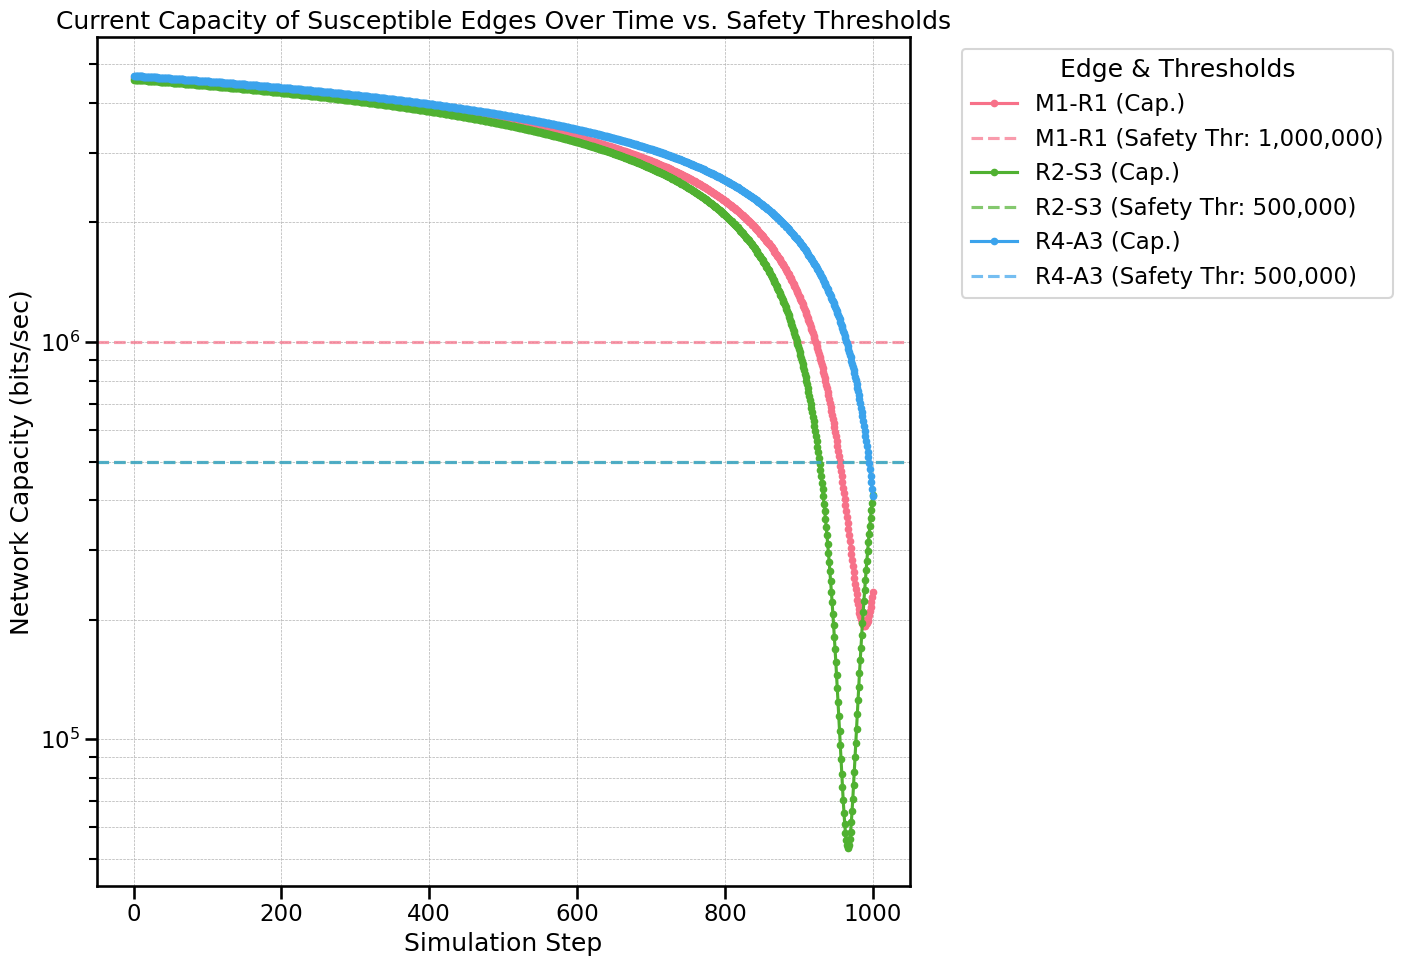

In [ ]:
if 'susceptible_df' in locals() and not susceptible_df.empty:
    plt.figure(figsize=(18, 10))
    
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('husl', n_colors=len(unique_edges))
    
    for i, edge_label_str in enumerate(unique_edges):
        edge_data = susceptible_df[susceptible_df['edge_label'] == edge_label_str]
        
        # Plot current capacity for the edge
        plt.plot(edge_data['step'], edge_data['current_capacity'], marker='.', linestyle='-', label=f"{edge_label_str} (Cap.)", color=palette[i])
        
        # Get the required safety capacity for this edge (should be constant for the edge)
        # Taking the first value as it's per edge, not per step for an edge.
        safety_threshold_for_edge = edge_data['required_safety_capacity'].iloc[0]
        
        # Plot the safety threshold line for this edge
        plt.axhline(y=safety_threshold_for_edge, color=palette[i], linestyle='--', alpha=0.7, 
                    label=f"{edge_label_str} (Safety Thr: {safety_threshold_for_edge:,.0f})")

    plt.title('Current Capacity of Susceptible Edges Over Time vs. Safety Thresholds')
    plt.xlabel('Simulation Step')
    plt.ylabel('Network Capacity (bits/sec)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Improve legend handling for many lines
    handles, labels = plt.gca().get_legend_handles_labels()
    # Create a dictionary to keep unique labels for the legend
    # This helps avoid duplicate legend entries if we plot capacity and threshold separately
    # However, the current labeling makes them unique already.
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Edge & Thresholds', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 0.80, 1]) # Adjust layout to make space for a potentially long legend
    plt.yscale('log') # Use log scale if capacities vary widely, otherwise linear
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Optional: scientific notation for y-axis
    
    plt.show()
elif 'susceptible_df' in locals() and susceptible_df.empty:
    print("No susceptible edges were found in the data (is_ew_susceptible was always False).")
    print("This could mean the jammer's selected BW area did not match any edge's BW area.")
    print("Check the 'EW_JAMMER_ACTUAL_BW_AREA' parameter in the simulation output and edge 'bw_area' values.")
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")

### Analysis of the Plot

The plot above shows how the `current_capacity` of communication links (for EW susceptible edges) changes as the drone swarm moves through the environment.

- **X-axis (Simulation Step)**: Represents time or progression of the swarm towards the EW source.
- **Y-axis (Network Capacity)**: The calculated `current_capacity` of the edge in bits/sec, after EW effects. A log scale might be used if values vary greatly.
- **Solid Lines**: Each colored solid line corresponds to the `current_capacity` of a specific communication edge between two drones that was susceptible to EW (i.e., its `bw_area` matched the jammer's).
- **Dashed Lines**: Each colored dashed line (matching its solid counterpart) represents the `required_safety_capacity` for that specific edge. An edge is considered inactive/disabled in the simulation if its `current_capacity` (solid line) drops below this threshold (dashed line).

**Interpreting the plot:**
- **Resilience**: Edges whose solid lines stay above their dashed threshold lines for more steps are more resilient to the EW in their assigned bandwidth area.
- **Degradation**: Observe how quickly the `current_capacity` for different edges drops. Some edges might be affected sooner or more severely than others.
- **Disable Point**: When a solid line crosses below its corresponding dashed line, that edge is considered disabled by the simulation logic. The step at which this occurs indicates how far that particular edge "survived" before its capacity fell below the safety requirement.